In [ ]:
# Load in spectrograms, split into training testing validation sets + labels

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import os
from scipy.stats import zscore


In [2]:
import scipy

In [3]:
from scipy.io import loadmat

# .mat file ordering

We can load three spectrograms for each channel, of which there are 62 channels. These three spectrograms are the entire spectrogram, no movement, movement. We only want the entire spec, which we have now, and now we want to coincide those with the movement times. 

# Main Loop

EDIT: This works assuming we have access to all the spectrograms of all the movments + all the night event files of those recordings, which is not the case. Instead, please see below where I have essentially the same loop, but only for recordings we finished labelling. 

TODO:

Compute z score across, use as indicator on whether or not to save. '

Or alternatively, look at pre-computed bad times, but I'm not seeing this yet?

In [4]:
nights = ['1803'+str(i) for i in range(26,32)]
recs = ['00'+str(i) for i in range(1,10)]
WINDOW_LENGTH = 10
thresh = 5 # start here .. 
for night in nights: # loop over nights (180327)
    for rec in recs: #loop over recordings (003)
        try: 
            # load spectrogram + night movements of that night recording
            allspec = loadmat('../Spectrogram_mat_data/N10W1dn1_'+ night + '_rec'+rec+'.mat')
            night_events = loadmat('/vol/sas2b/Goose_Multiscale_M1_Wireless/'+night+'/'+rec+'/rec'+rec+'.NightEvents.mat')
            video_start = night_events['NightEvents'][0][0][0][0][0][0][0][0]
            video_stop = night_events['NightEvents'][0][0][0][0][0][1][0][0]
            video_length = video_stop - video_start
            try:
                mvmt_starts = night_events['NightEvents'][0][0][1][0][0][0][0]
                mvmt_ends = night_events['NightEvents'][0][0][1][0][0][1][0]
                has_movements = True #transitions 
            except:
                has_movements = False
                
            for ch in range(1): # iterate over channels (just one for now)
                spec = allspec['Spec_per_Ch'][0][0][ch][0][0][0]  
                prior_mvmt = 0
                if has_movements:
                    for start, end in zip(mvmt_starts,mvmt_ends): # loop over movements
                        mvmt_start = (spec.shape[0] / video_length) * start
                        mvmt_end = (spec.shape[0] / video_length) * end #
                        window = int(round(spec.shape[0] / video_length)) *WINDOW_LENGTH
                        asleep = torch.from_numpy(spec[int(round(prior_mvmt)):int(round(mvmt_start)),:])
                        moving = torch.from_numpy(spec[int(round(mvmt_start)):int(round(mvmt_end)),:])
                        #print(' window size = ', window)
                        # after indexing split into windows
                        asleeps = torch.split(asleep,split_size_or_sections=window,dim=0)
                        movings = torch.split(moving,split_size_or_sections=window,dim=0)
                        prior_mvmt  = mvmt_end # for the next loop

                        # loop over these windows and save 
                        for i, sleep_arr in enumerate(asleeps):
                            if not torch.isnan(sleep_arr.sum()):
                                totz = zscore(abs(sleep_arr.sum(axis=1))) #flip abs before sum
                                if not np.any(abs(totz) > thresh):
                                    if sleep_arr.shape[0] == window:
                                        np.save('data/sleep/' + night + '_' + rec + '_' + str(ch) + '_win'+str(i) +'_sleep.npy',sleep_arr.numpy().T) 
                                else:
                                    print(night, rec, i, "has badtimes.")
                        for i, sleep_arr in enumerate(movings):
                            if not torch.isnan(sleep_arr.sum()):
                                totz = zscore(abs(sleep_arr.sum(axis=1)))
                                if not np.any(abs(totz) > thresh):
                                #  print(sleep_arr.shape)
                                    if sleep_arr.shape[0] == window:
                                        np.save('data/move/' + night + '_' + rec + '_' + str(ch) + '_win'+str(i) +'_move.npy',sleep_arr.numpy().T)
                                else:
                                    print(night, rec, i, "has badtimes.")
                else:
                    prior_rec = '00' + str(int(rec) - 1)
                    print("Using prior rec..")
                    night_events = loadmat('/vol/sas2b/Goose_Multiscale_M1_Wireless/'+night+'/'+prior_rec+'/rec'+prior_rec+'.NightEvents.mat')
                    video_start = night_events['NightEvents'][0][0][0][0][0][0][0][0]
                    video_stop = night_events['NightEvents'][0][0][0][0][0][1][0][0]
                    video_length = video_stop - video_start

                    mvmt_starts = night_events['NightEvents'][0][0][1][0][0][0][0]
                    mvmt_ends = night_events['NightEvents'][0][0][1][0][0][1][0]
                    if mvmt_ends[-1] < video_stop:
                        print("Saving new events.")
                        asleeps = torch.split(asleep,split_size_or_sections=window,dim=0)
                        for i, sleep_arr in enumerate(asleeps):
                            if not torch.isnan(sleep_arr.sum()):
                                totz = zscore(abs(sleep_arr.sum(axis=1)))
                                if not np.any(abs(totz) > thresh):
                                #  print(sleep_arr.shape)
                                    if sleep_arr.shape[0] == window:
                                        np.save('data/sleep/' + night + '_' + rec + '_' + str(ch) + '_win'+str(i) +'_sleep.npy',sleep_arr.numpy().T)
                                else:
                                    print(night, rec, i, "has badtimes.")
                    else:
                        movings = torch.split(moving,split_size_or_sections=window,dim=0)
                        for i, sleep_arr in enumerate(movings):
                            if not torch.isnan(sleep_arr.sum()): # print where this happens
                                totz = zscore(abs(sleep_arr.sum(axis=1)))
                                if not np.any(abs(totz) > thresh):
                                
                                    #  print(sleep_arr.shape)
                                    if sleep_arr.shape[0] == window:
                                        np.save('data/move/' + night + '_' + rec + '_' + str(ch) + '_win'+str(i) +'_move.npy',sleep_arr.numpy().T)
                                else:
                                    print(night, rec, i, "has badtimes.")
            # From here I suspect it would be easy to load in 
        except Exception as e:
            print(e)
            print("Couldn't do ", night, " ", rec)
            # This means I look at this night separately, and from it I can infer what state
            # the monkey is in based on how it was as the end of the previous recording
            pass

[Errno 2] No such file or directory: '../Spectrogram_mat_data/N10W1dn1_180326_rec001.mat'
Couldn't do  180326   001
string index out of range
Couldn't do  180326   002


/home/bijanadmin/anaconda3/envs/monkey/lib/python3.8/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/home/bijanadmin/anaconda3/envs/monkey/lib/python3.8/site-packages/scipy/stats/stats.py:2497: RuntimeWarning: Mean of empty slice.
  mns = a.mean(axis=axis, keepdims=True)
/home/bijanadmin/anaconda3/envs/monkey/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/bijanadmin/anaconda3/envs/monkey/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/bijanadmin/anaconda3/envs/monkey/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/bijanadmin/anaconda3/envs/monkey/lib/python3.8/site-packages/numpy/core/_methods.py:

split_size can only be 0 if dimension size is 0, but got dimension size of 1
Couldn't do  180326   004
Using prior rec..
Saving new events.
Using prior rec..
index 0 is out of bounds for axis 0 with size 0
Couldn't do  180326   007
Using prior rec..
index 0 is out of bounds for axis 0 with size 0
Couldn't do  180326   008
Using prior rec..
index 0 is out of bounds for axis 0 with size 0
Couldn't do  180326   009
[Errno 2] No such file or directory: '../Spectrogram_mat_data/N10W1dn1_180327_rec006.mat'
Couldn't do  180327   006
Using prior rec..
Saving new events.
[Errno 2] No such file or directory: '../Spectrogram_mat_data/N10W1dn1_180328_rec001.mat'
Couldn't do  180328   001
[Errno 2] No such file or directory: '../Spectrogram_mat_data/N10W1dn1_180328_rec002.mat'
Couldn't do  180328   002
[Errno 2] No such file or directory: '../Spectrogram_mat_data/N10W1dn1_180328_rec007.mat'
Couldn't do  180328   007
[Errno 2] No such file or directory: '../Spectrogram_mat_data/N10W1dn1_180328_rec00

Now let's see if this makes sense when reading in a random file...

<ipython-input-23-a54d81529dce>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


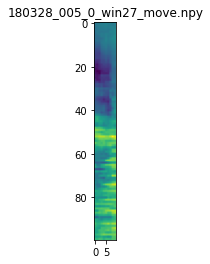

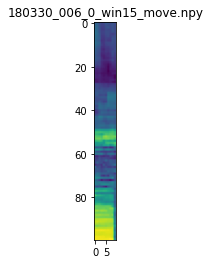

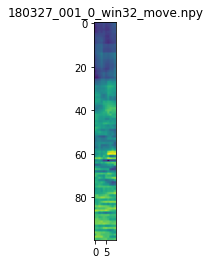

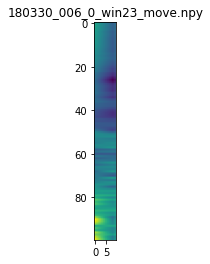

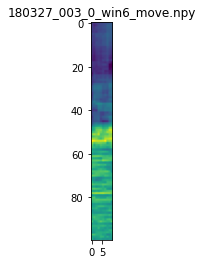

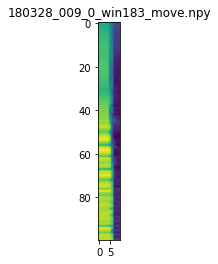

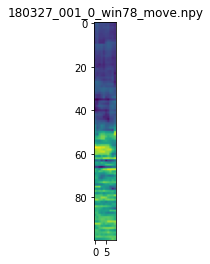

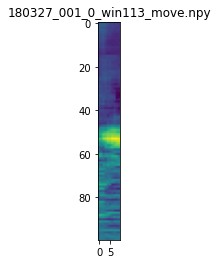

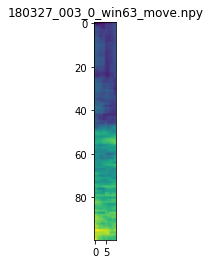

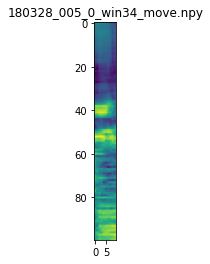

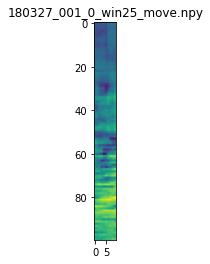

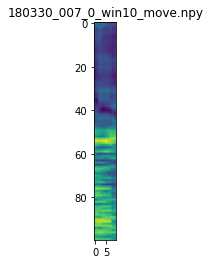

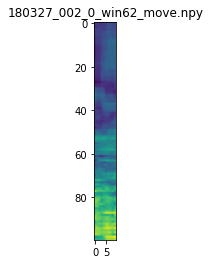

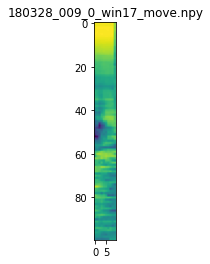

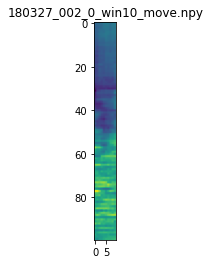

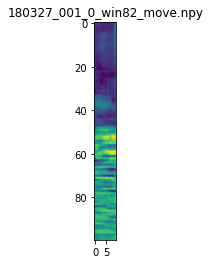

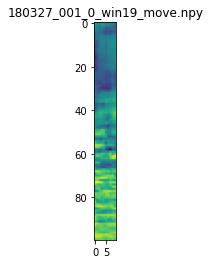

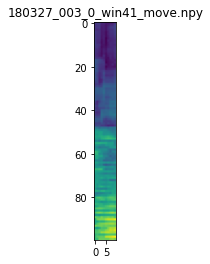

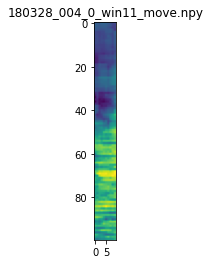

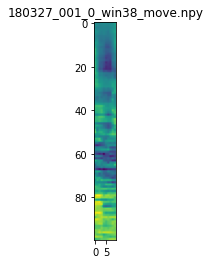

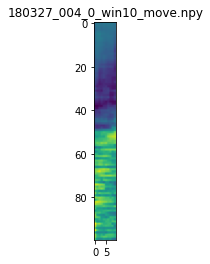

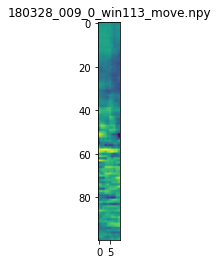

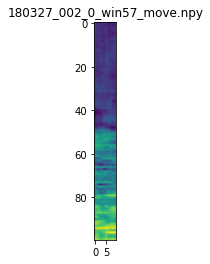

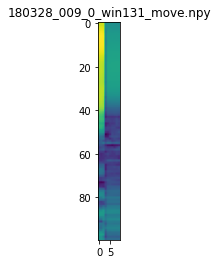

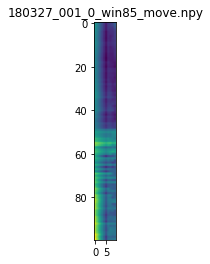

In [23]:
for move_spec in os.listdir('data/move/')[:25]:
    plt.figure()
    plt.title(move_spec)
    plt.imshow(np.load('data/move/'+move_spec))
    #break

<ipython-input-24-8351265ef32a>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


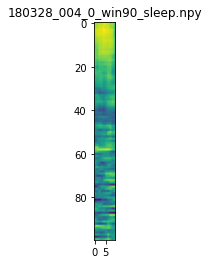

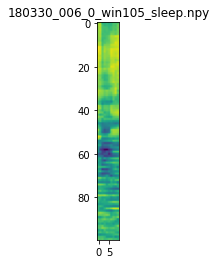

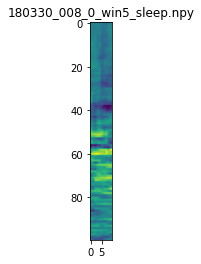

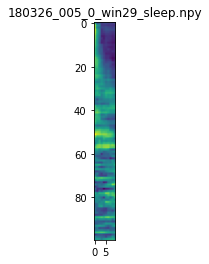

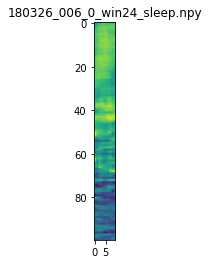

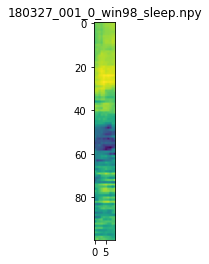

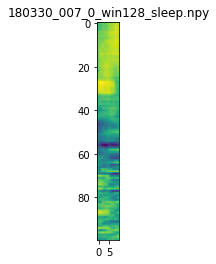

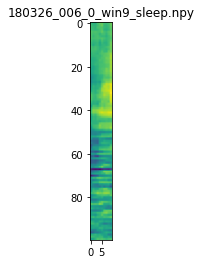

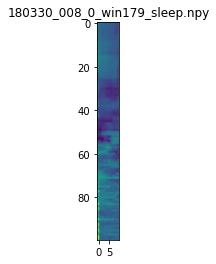

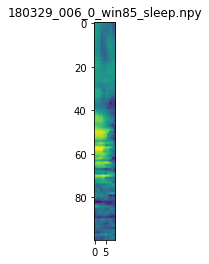

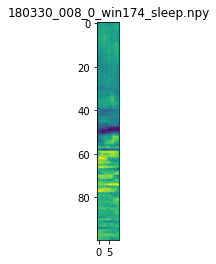

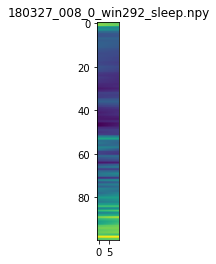

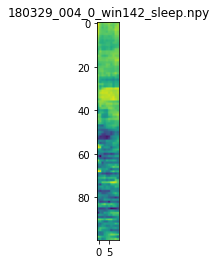

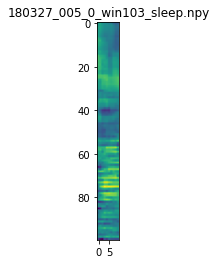

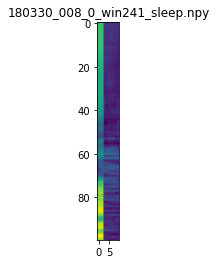

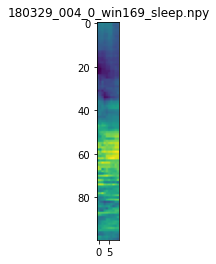

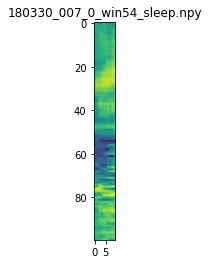

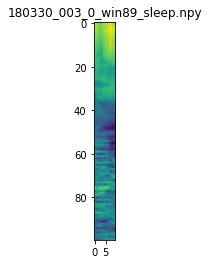

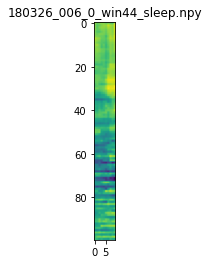

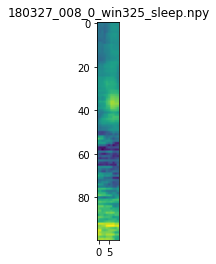

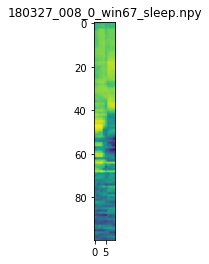

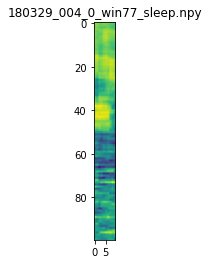

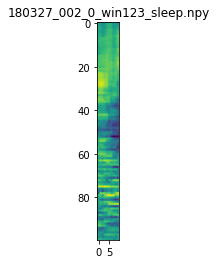

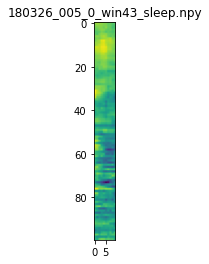

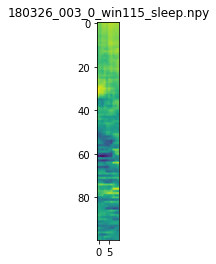

In [24]:
for sleep_spec in os.listdir('data/sleep/')[:25]:
    plt.figure()
    plt.title(sleep_spec)
    plt.imshow(np.load('data/sleep/'+sleep_spec))
    #break

In [13]:
test_sleep_spec = np.load('data/sleep/180326_003_0_win103_sleep.npy')

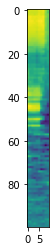

In [14]:
plt.imshow(test_sleep_spec)

### Fixing the mistake

So there are two possible failure cases 

1) No night events file created yet, which just means there's nothing to match to a label just yet.

2) There is a night events file, but there is no movement files. If that's the case, then it means the monkey is in the same state they were in at the end of the prior recording. 

3) After doing 2, it's possible that the prior recording also wasn't labeled. 

In [ ]:
# start with 180327   006
night = '180328'
rec = '001'
allspec = loadmat('../Spectrogram_mat_data/N10W1dn1_'+ night + '_rec'+rec+'.mat')
night_events = loadmat('/vol/sas2b/Goose_Multiscale_M1_Wireless/'+night+'/'+rec+'/rec'+rec+'.NightEvents.mat')
video_start = night_events['NightEvents'][0][0][0][0][0][0][0][0]
video_stop = night_events['NightEvents'][0][0][0][0][0][1][0][0]
video_length = video_stop - video_start

#mvmt_starts = night_events['NightEvents'][0][0][1][0][0][0][0]
#mvmt_ends = night_events['NightEvents'][0][0][1][0][0][1][0]
# So there are no night events. 

# In this case, head to the prior recording, load in those movements



In [ ]:
allspec

In [ ]:
prior_rec = '00' + str(int(rec) - 1)

night_events = loadmat('/vol/sas2b/Goose_Multiscale_M1_Wireless/'+night+'/'+prior_rec+'/rec'+prior_rec+'.NightEvents.mat')
video_start = night_events['NightEvents'][0][0][0][0][0][0][0][0]
video_stop = night_events['NightEvents'][0][0][0][0][0][1][0][0]
video_length = video_stop - video_start

mvmt_starts = night_events['NightEvents'][0][0][1][0][0][0][0]
mvmt_ends = night_events['NightEvents'][0][0][1][0][0][1][0]


In [ ]:
plt.imshow(np.load('data/sleeping/180327_009_0_win7_sleep.npy'))

In [ ]:
video_stop

In [ ]:
if mvmt_ends[-1] < video_stop:
    print("Monkey was asleep as the end of ", prior_rec, ' so label all of ', rec, ' as asleep')

Use just available data, 

In [ ]:
for file in os.listdir('../Spectrogram_mat_data/'):
    night = file.split('_')[1]
    rec = file.split('.')[0][-3:]
    allspec = loadmat('../Spectrogram_mat_data/N10W1dn1_'+ night + '_rec'+rec+'.mat')
    night_events = loadmat('/vol/sas2b/Goose_Multiscale_M1_Wireless/'+night+'/'+rec+'/rec'+rec+'.NightEvents.mat')
    video_start = night_events['NightEvents'][0][0][0][0][0][0][0][0]
    video_stop = night_events['NightEvents'][0][0][0][0][0][1][0][0]
    video_length = video_stop - video_start

    mvmt_starts = night_events['NightEvents'][0][0][1][0][0][0][0]
    mvmt_ends = night_events['NightEvents'][0][0][1][0][0][1][0]


    for ch in range(1): # iterate over channels (just one for now)
        spec = allspec['Spec_per_Ch'][0][0][ch][0][0][0]  
        prior_mvmt = 0
        for start, end in zip(mvmt_starts,mvmt_ends): # loop over movements
            mvmt_start = (spec.shape[0] / video_length) * start
            mvmt_end = (spec.shape[0] / video_length) * end
            window = int(round(spec.shape[0] / video_length)) *WINDOW_LENGTH

            asleep = torch.from_numpy(spec[int(round(prior_mvmt)):int(round(mvmt_start)),:])
            moving = torch.from_numpy(spec[int(round(mvmt_start)):int(round(mvmt_end)),:])

            # after indexing split into windows
            asleeps = torch.split(asleep,split_size_or_sections=window,dim=0)

            movings = torch.split(moving,split_size_or_sections=window,dim=0)
            prior_mvmt  = mvmt_end # for the next loop

            # loop over these windows and I guess save? 
            for sleep_arr in asleeps:
              #  print(sleep_arr.shape)
                if sleep_arr.shape[0] == WINDOW_LENGTH:
                    np.save('data/sleeping/' + night + '_' + rec + '_' + str(ch) + '_sleep.npy',sleep_arr.numpy().T)
                    # save as a npy file?
            for sleep_arr in movings:
               # print(sleep_arr.shape)
                if sleep_arr.shape[0] == WINDOW_LENGTH:

                    # save as a npy file? 
                    np.save('data/moving/' + night + '_' + rec + '_' + str(ch) + '_move.npy',sleep_arr.numpy().T)

    # From here I suspect it would be easy to load in 



Rec 8 on 326, is there no movement or all movemnt? What should we say in this case? 

In [ ]:
 spec = allspec['Spec_per_Ch'][0][0][ch][0][0][0]

In [ ]:
plt.imshow(spec.T[:,0:100])

In [ ]:
plt.imshow(np.load('data/moving/180327_001_0_move.npy'))

In [ ]:
plt.imshow(np.load('data/sleeping/180327_001_0_win117_sleep.npy'))

Possibilities, if in recording 1 no movement mentioned, then we assume the monkey was moving the whole time. 

In [ ]:
len(os.listdir('data/moving/'))

In [ ]:
len(os.listdir('data/sleeping/'))